# SageMaker Pipelines

Amazon SageMaker Pipelines es un servicio que ofrece un flujo de trabajo automatizado para tareas de aprendizaje automático, facilitando la orquestación y ejecución de procesos complejos. A continuación se describen las actividades fundamentales que soportan estos pipelines:

## Actividades Soportadas por SageMaker Pipelines

1. **Pipelines**:
   - Un **Pipeline** es un grafo acíclico dirigido (DAG) que define una secuencia de pasos y condiciones para orquestar trabajos y crear recursos en SageMaker.

2. **Processing Job Steps**:
   - Estos pasos ofrecen una manera simplificada y gestionada de ejecutar cargas de trabajo de procesamiento de datos. Son útiles para tareas como ingeniería de características, validación de datos, evaluación de modelos e interpretación de modelos.

3. **Training Job Steps**:
   - Este paso implica un proceso iterativo donde se entrena un modelo para hacer predicciones al presentarle ejemplos de un conjunto de datos de entrenamiento.

4. **Conditional Execution Steps**:
   - Permite la ejecución condicional de ramas dentro de un pipeline, basado en criterios predefinidos.

5. **Register Model Steps**:
   - Crea un paquete de modelo en el Registro de Modelos, que puede usarse para generar modelos implementables en Amazon SageMaker.

6. **Create Model Steps**:
   - Genera un modelo para su uso en pasos de transformación o para su posterior publicación como un endpoint.

7. **Transform Job Steps**:
   - Realiza transformaciones por lotes para preprocesar datasets eliminando ruido o sesgo que interferiría con el entrenamiento o inferencia, obtener inferencias de grandes conjuntos de datos, y ejecutar inferencias cuando no se requiere un endpoint persistente.

8. **Fail Steps**:
   - Detiene la ejecución de un pipeline y marca la ejecución como fallida.

9. **Parametrized Pipeline Executions**:
   - Permite la variación en la ejecución de pipelines según parámetros especificados, brindando flexibilidad al cambiar dinámicamente aspectos como rutas de datos o configuraciones de entrenamiento.

## Beneficios de Usar SageMaker Pipelines

- **Automatización**: Automatiza los procesos de aprendizaje automático, reduciendo la necesidad de intervención manual.
- **Reproducibilidad**: Ofrece una manera consistente de reproducir resultados, crucial para la experimentación de IA/ML.
- **Escalabilidad**: Permite manejar tareas complejas y pesadas en rendimiento a escala en la infraestructura de AWS.
- **Flexibilidad**: Soporta ejecuciones paramétricas, proporcionando la capacidad de ajustar y reutilizar pipelines para diferentes escenarios y datasets.

SageMaker Pipelines es una herramienta poderosa para gestionar eficientemente el ciclo de vida de modelos de aprendizaje automático, desde el preprocesamiento de datos hasta el despliegue y más allá.


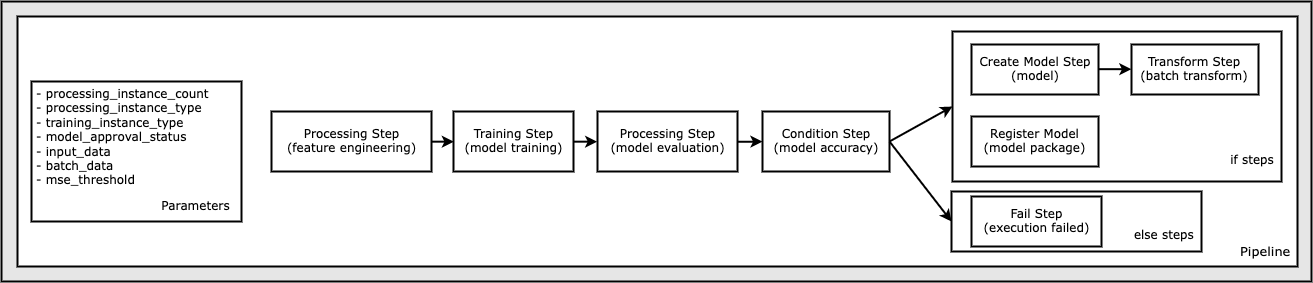

Dataset https://archive.ics.uci.edu/dataset/1/abalone

In [5]:
import sys

import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession

In [6]:
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()


In [7]:
pipeline_session = PipelineSession()
default_bucket = sagemaker_session.default_bucket()
model_package_group_name = f"AbaloneModelPackageGroupName"

In [8]:
!mkdir -p data

In [9]:
local_path = "data/abalone-dataset.csv"

s3 = boto3.resource("s3")
s3.Bucket(f"sagemaker-example-files-prod-{region}").download_file(
    "datasets/tabular/uci_abalone/abalone.csv", local_path
)

base_uri = f"s3://{default_bucket}/abalone" # representa la ubicación base en Amazon S3 donde se almacenarán los archivos de datos
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
) # contendrá la URI completa de S3 donde se almacenó el archivo subido
print(input_data_uri)

s3://sagemaker-us-east-1-221082178761/abalone/abalone-dataset.csv


In [10]:
base_uri

's3://sagemaker-us-east-1-221082178761/abalone'

* vamos a descargar un segundo conjunto de datos para la transformación por lotes tras la creación del modelo

In [11]:
local_path = "data/abalone-dataset-batch"

s3 = boto3.resource("s3")
s3.Bucket(f"sagemaker-servicecatalog-seedcode-{region}").download_file(
    "dataset/abalone-dataset-batch", local_path
)

base_uri = f"s3://{default_bucket}/abalone"
batch_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)
print(batch_data_uri)

s3://sagemaker-us-east-1-221082178761/abalone/abalone-dataset-batch


___________

# Definir Parámetros para Parametrizar la Ejecución de un Pipeline

En Amazon SageMaker, los **parámetros de pipeline** son una herramienta poderosa que te permite personalizar la ejecución de pipelines sin necesidad de modificar la definición del pipeline en sí. Esto significa que puedes realizar ejecuciones personalizadas y programar tareas de forma flexible.

## Tipos de Parámetros Soportados

Los pipelines en SageMaker admiten varios tipos de parámetros, que te permiten ingresar diferentes tipos de datos:

- **ParameterString**: Representa un tipo de dato `str` de Python, utilizado para manejar texto.
- **ParameterInteger**: Representa un tipo de dato `int` de Python, utilizado para números enteros.
- **ParameterFloat**: Representa un tipo de dato `float` de Python, utilizado para números con decimales.

Estos parámetros pueden tener un valor predeterminado, que puede ser cambiado o sobreescrito al ejecutar el pipeline. Asegúrate de que el valor predeterminado sea del tipo correcto de parámetro.

## Parámetros en el Ejemplo

Los siguientes parámetros han sido definidos en este flujo de trabajo de ejemplo:

1. **processing_instance_count**:
   - Define la cantidad de instancias que se utilizarán en el trabajo de procesamiento.

2. **instance_type**:
   - Especifica el tipo de instancia ml.\* que se usará en el trabajo de entrenamiento. 

3. **model_approval_status**:
   - El estado de aprobación que se registrará con el modelo entrenado para fines de CI/CD. Por defecto es “PendingManualApproval”.

4. **input_data**:
   - La ubicación URI del bucket en S3 donde se encuentran los datos de entrada.

5. **batch_data**:
   - La ubicación URI del bucket en S3 donde se encuentran los datos por lotes.

6. **mse_threshold**:
   - El umbral de Error Cuadrático Medio (MSE) utilizado para verificar la precisión de un modelo.

Utilizando estos parámetros, puedes controlar cómo se ejecuta el pipeline, ajustando detalles específicos como la cantidad de recursos y los datos que se procesarán, sin cambiar la estructura básica del pipeline. Esto ofrece una gran flexibilidad y adaptabilidad a tus necesidades específicas.

In [12]:
input_data_uri

's3://sagemaker-us-east-1-221082178761/abalone/abalone-dataset.csv'

In [13]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1) # cantidad de instancias
instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge") # tipo de instancia
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
) # status del modelo para ser utilizado en entornos productivos o ser consumidos por un endpoint

input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri, # abalone dataset
)
batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri, # batch dataset
)
mse_threshold = ParameterFloat(name="MseThreshold", default_value=6.0) 


--------
## Definir un Paso de Procesamiento para la Ingeniería de Características

## ¿Qué es un Paso de Procesamiento?

Un **Paso de Procesamiento** es una parte clave en la preparación de datos para el entrenamiento de modelos de machine learning. Aquí, vamos a desarrollar un script de preprocesamiento que será usado en este paso.

## Desarrollo del Script de Preprocesamiento

En esta sección, crearemos un archivo llamado `preprocessing_abalone.py`. Este archivo contiene todo el código necesario para preparar nuestros datos usando la librería `scikit-learn`.

### ¿Qué Hace el Script de Preprocesamiento?

1. **Completar Datos Faltantes**:
   - Si faltan datos en la categoría de "sexo", los completamos y luego los codificamos para que puedan ser utilizados en el entrenamiento del modelo.

2. **Escalar y Normalizar Datos Numéricos**:
   - Preparamos todos los campos numéricos (excepto "sexo" y "anillos") para garantizar que estén en la misma escala, lo que es importante para el rendimiento del modelo.

3. **Dividir los Datos**:
   - Separamos los datos en tres partes: 
     - **Entrenamiento**: Para enseñar al modelo.
     - **Validación**: Para ajustar y validar el modelo durante el entrenamiento.
     - **Prueba**: Para evaluar el rendimiento final del modelo.

## ¿Cómo Funciona en el Pipeline?

- **Paso de Procesamiento**: Ejecuta el script en los datos de entrada para prepararlos adecuadamente.
- **Paso de Entrenamiento**: Utiliza las características y etiquetas ya preprocesadas para entrenar el modelo.
- **Paso de Evaluación**: Usa el modelo entrenado junto con las características y etiquetas de prueba preprocesadas para evaluar cuán bien funciona el modelo.

### ¿Por Qué es Importante?

Preprocesar los datos asegura que nuestro modelo reciba información clara y coherente, lo que puede mejorar significativamente la precisión y eficacia del modelo. Ajustar cuidadosamente cada paso te ayudará a obtener resultados más fiables y sólidos, lo cual es fundamental para proyectos exitosos de machine learning.

In [15]:
!mkdir -p code

In [16]:
%%writefile code/preprocessing.py

import argparse
import os
import requests
import tempfile

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Since we get a headerless CSV file, we specify the column names here.
feature_columns_names = [
    "sex",
    "length",
    "diameter",
    "height",
    "whole_weight",
    "shucked_weight",
    "viscera_weight",
    "shell_weight",
]
label_column = "rings"

feature_columns_dtype = {
    "sex": str,
    "length": np.float64,
    "diameter": np.float64,
    "height": np.float64,
    "whole_weight": np.float64,
    "shucked_weight": np.float64,
    "viscera_weight": np.float64,
    "shell_weight": np.float64,
}

label_column_dtype = {"rings": np.float64}


def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z


if __name__ == "__main__":
    base_dir = "/opt/ml/processing"

    df = pd.read_csv(
        f"{base_dir}/input/abalone-dataset.csv",
        header=None,
        names=feature_columns_names + [label_column],
        dtype=merge_two_dicts(feature_columns_dtype, label_column_dtype),
    )
    numeric_features = list(feature_columns_names)
    numeric_features.remove("sex")

    # pipeline for numeric features 
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )
    
    # pipeline for categorical features
    categorical_features = ["sex"]
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    # preprocessor step with pipelines 
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    y = df.pop("rings")
    X_pre = preprocess.fit_transform(df)
    y_pre = y.to_numpy().reshape(len(y), 1)

    X = np.concatenate((y_pre, X_pre), axis=1)

    np.random.shuffle(X)
    
    train, validation, test = np.split(X, [int(0.7 * len(X)), int(0.85 * len(X))])

    pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
    
    pd.DataFrame(validation).to_csv(
        f"{base_dir}/validation/validation.csv", header=False, index=False
    )
    
    pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)

Writing code/preprocessing.py


Nota:

* SageMaker se encarga automáticamente de transferir el archivo desde la URI de S3 especificada a un directorio temporal dentro del contenedor donde se realiza el procesamiento. Por lo general, este directorio temporal es una subruta de /opt/ml/processing/input. No necesitas hacer nada para que este paso suceda, ya que está gestionado por SageMaker.

creando el procesador con sklearn. 

In [18]:
processing_instance_count

ParameterInteger(name='ProcessingInstanceCount', parameter_type=<ParameterTypeEnum.INTEGER: 'Integer'>, default_value=1)

In [19]:
pipeline_session

In [17]:
from sagemaker.sklearn.processing import SKLearnProcessor


framework_version = "1.2-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.xlarge",
    instance_count=processing_instance_count,
    base_job_name="sklearn-abalone-process", #jon name
    role=role,
    sagemaker_session=pipeline_session,
)

[03/30/25 23:03:36] INFO     Defaulting to only available      ]8;id=299580;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=926241;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\
                             Python version: py3                                


# Cómo Usar el Resultado del Método .run() en un Pipeline de SageMaker

En el contexto de Amazon SageMaker Pipelines, es importante entender cómo fluyen los datos entre los diferentes pasos del pipeline. Aquí te explicamos de forma sencilla cómo funciona este proceso.

## Uso del Método .run() del Procesador

1. **Obtener Resultados del Procesador**:
   - Cuando trabajas con procesamiento de datos, normalmente llamarías al método `.run()` para ejecutar un trabajo de procesamiento de inmediato. Sin embargo, en un pipeline, no ejecutamos el trabajo directamente. En su lugar, obtenemos los argumentos necesarios para definir el trabajo como parte del pipeline.

2. **Integración en el Pipeline**:
   - Al pasar `pipeline_session` a `sagemaker_session`, el método `.run()` no lanza el trabajo automáticamente. En cambio, devuelve los argumentos necesarios que SageMaker usa para ejecutar el trabajo dentro del pipeline.
   - Esto nos permite tener un control estructurado y secuencial sobre cómo y cuándo se ejecutan los trabajos en el pipeline.

## Canales de Datos Nombrados

- **"train_data" y "test_data"**:
  - Estos son nombres dados a los conjuntos de datos que estamos procesando. Es como etiquetar los datos para que el pipeline sepa qué datos son para el entrenamiento y qué datos son para las pruebas.
  - Facilita la organización y claridad del flujo de trabajo, al definir exactamente qué parte de los datos está destinada a cada proceso.

## Propiedades de Paso

- **¿Qué Son las Propiedades de Paso?**:
  - Son detalles o referencias que puedes definir en un paso del pipeline que se pueden usar en los pasos siguientes.
  - Permiten que los resultados de un paso sean usados por el siguiente paso sin que tengas que volver a definir o procesar esos resultados.

- **Ejecución en Tiempo de Ejecución**:
  - Las propiedades de paso se resuelven en sus valores concretos al momento de ejecutar el pipeline, asegurando que los pasos reciban y utilicen los datos correctos.

## Aplicación en el Paso de Entrenamiento

- Al definir el paso de entrenamiento en el pipeline, usas las propiedades y salidas de pasos anteriores (como el procesamiento de datos) para especificar qué datos se deben utilizar.
- Esto asegura que el flujo de datos sea lógico y que el modelo se entrene con los datos preparados y etiquetados correctamente.

### Resumen

Este proceso en los pipelines de SageMaker asegura una estructura limpia y eficaz para automatizar tareas de procesamiento y entrenamiento de datos, permitiendo un flujo secuencial y ordenado que es fácil de seguir y manejar. Esto es clave para mantener los proyectos de machine learning organizados y escalables.

In [20]:
input_data

ParameterString(name='InputData', parameter_type=<ParameterTypeEnum.STRING: 'String'>, default_value='s3://sagemaker-us-east-1-221082178761/abalone/abalone-dataset.csv')


## Nota importante 
SageMaker utiliza contenedores Docker gestionados para ejecutar trabajos de procesamiento, entrenamiento e inferencia. Cada uno de estos contenedores tiene una estructura de directorios predefinida.
Ubicación de Datos en el Contenedor:

* "/opt/ml/processing/input": Es la ubicación dentro del contenedor donde SageMaker coloca automáticamente los datos que especificas en tu trabajo de procesamiento. Este directorio es accesible solo dentro del contenedor durante la ejecución del trabajo.
* "/opt/ml/processing/output": De manera similar, este es el directorio donde se espera que tu script escriba los resultados de salida. Al finalizar el trabajo, los archivos generados en este directorio se pueden cargar de nuevo a S3 o usados en pasos posteriores del pipeline.
* "/opt/ml/model": En trabajos de entrenamiento, este directorio se utiliza para guardar el modelo entrenado.

In [21]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code="code/preprocessing.py",
)

step_process = ProcessingStep(name="AbaloneProcess", step_args=processor_args)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


______

## Definir un Paso de Entrenamiento para Entrenar un Modelo

En esta parte, utilizamos el algoritmo XGBoost de Amazon SageMaker para entrenar un modelo con nuestro conjunto de datos.

## Configuración del Proceso de Entrenamiento

1. **Configurar el Estimador de XGBoost**:
   - Un **estimador** es como un chef que sigue una receta específica (el algoritmo XGBoost, en este caso) para crear un modelo de aprendizaje automático.
   - El **conjunto de datos de entrada** es como los ingredientes que el chef necesita; se proporciona a través de canales de entrada.

2. **Script de Entrenamiento**:
   - Este script hace varias cosas:
     - **Carga los Datos**: Toma los datos desde las ubicaciones de entrada especificadas.
     - **Configura los Hiperparámetros**: Ajusta configuraciones específicas del modelo que afectan el entrenamiento, como la cantidad de pasos de entrenamiento o la tasa de aprendizaje.
     - **Entrena el Modelo**: Usa los datos para enseñar al modelo a realizar predicciones.
     - **Guarda el Modelo**: Almacena el modelo entrenado en un directorio llamado `model_dir` para que pueda ser utilizado más tarde.

3. **Ruta del Modelo**:
   - Especificamos una ruta donde el modelo entrenado será guardado al final del entrenamiento. Esto asegura que el modelo pueda ser desplegado o reutilizado en el futuro.

## Nota sobre `instance_type`

- **Parameter `instance_type`**:
  - Este parámetro define el tipo de computadora virtual que se usará para entrenar el modelo. ¡Piensa en ello como elegir si necesitas una laptop sencilla o una supercomputadora!
  - **Reutilización en el Pipeline**: Puedes usar el mismo tipo de instancia en diferentes partes del pipeline para mantener consistencia y optimización de recursos.

Este flujo organiza el proceso de entrenamiento de forma clara y eficiente, asegurando que tu modelo esté listo para ser probado y, eventualmente, puesto en acción.

In [22]:
default_bucket

'sagemaker-us-east-1-221082178761'

In [23]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput

model_path = f"s3://{default_bucket}/AbaloneTrain"

image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=instance_type,
    instance_count=1,
    output_path=model_path,
    role=role,
    sagemaker_session=pipeline_session,
)
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
)

train_args = xgb_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)


[03/30/25 23:11:56] INFO     SageMaker Python SDK will   ]8;id=429303;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=169256;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             collect telemetry to help                          
                             us better understand our                           
                             user's needs, diagnose                             
                             issues, and deliver                                
                             additional features.                               
                             To opt out of telemetry,                           
                             please disable via                                 
                             TelemetryOptOut parameter                          
                             in SDK defaults con

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(



_______

## Uso del Salida de .fit() en un Paso de Entrenamiento del Pipeline

## Integración de Entrenamiento en el Pipeline

En el último paso, utilizamos la salida del método `.fit()` del estimador para configurar el `TrainingStep` dentro de nuestro pipeline en SageMaker. 

### Configuración del TrainingStep

1. **Uso de .fit() para Obtener Argumentos**:
   - Llamar a `estimator.fit()` normalmente iniciaría un trabajo de entrenamiento. Sin embargo, al pasar `pipeline_session` al `sagemaker_session`, la llamada a `.fit()` no ejecuta el trabajo inmediatamente. En su lugar, devuelve los argumentos necesarios para definir el trabajo de entrenamiento como un paso en el pipeline.

2. **Canales de Datos en S3**:
   - **`train_data`**: Se pasa la URI en S3 del canal de salida de datos de entrenamiento al método `.fit()`. Este es el equivalente a decirle al modelo qué datos usar para aprender.
   - **`test_data`**: Utilizamos el canal de salida `test_data` para evaluar el modelo dentro del pipeline, asegurando que funcione bien con datos que no ha visto antes.

### Propiedades de los Pasos del Pipeline

- **Uso de Propiedades**:
  - Cada etapa del pipeline tiene un atributo de propiedades que refleja el modelo de objeto de la respuesta correspondiente de una llamada a `describe`. Esto permite usar valores como marcadores de posición, que luego se resuelven cuando el pipeline se ejecuta realmente.
  - **Ejemplo**: Las propiedades de un `ProcessingStep` se alinean con el objeto de respuesta `DescribeProcessingJob`, lo que hace que los datos y resultados sean accesibles de forma dinámica en tiempo de ejecución.



In [25]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


step_train = TrainingStep(
    name="AbaloneTrain",
    step_args=train_args,
)

--------
## Paso de Evaluación del Modelo en el Pipeline

## Evaluación del Modelo Entrenado

Este paso en el pipeline nos ayuda a revisar qué tan bien funciona el modelo una vez que ha sido entrenado. 

### Desarrollo del Script de Evaluación

1. **Crear el Script de Evaluación**:
   - Este script es parte de un paso de procesamiento que evalúa el modelo.

2. **¿Qué Hace el Script de Evaluación?**:
   - **Carga el Modelo**: Usa el modelo entrenado anteriormente.
   - **Lee los Datos de Prueba**: Toma datos que el modelo no ha visto antes para probar su eficiencia.
   - **Realiza Predicciones**: Predice resultados usando los datos de prueba.
   - **Genera un Informe de Clasificación**: Incluye métricas como precisión y la Curva ROC para medir el rendimiento.

3. **Resultado de la Evaluación**:
   - Guarda un reporte detallado de la evaluación en un archivo llamado `evaluation.json`, almacenado en el directorio de evaluación.

### ¿Qué Puedes Hacer Después?

- Una vez que el pipeline se ejecuta, puedes revisar `evaluation.json` para comprender cómo está funcionando tu modelo y si necesitas hacer ajustes para mejorar su precisión.

Con esta evaluación, te aseguras de que el modelo no solo aprende de los datos de entrenamiento, sino que también puede generalizar correctamente a nuevos datos. ¡Es como un chequeo final para tu modelo!

In [26]:
%%writefile code/evaluation.py
import json
import pathlib
import pickle
import tarfile

import joblib
import numpy as np
import pandas as pd
import xgboost

from sklearn.metrics import mean_squared_error


if __name__ == "__main__":
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    model = pickle.load(open("xgboost-model", "rb"))

    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)

    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)

    X_test = xgboost.DMatrix(df.values)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    std = np.std(y_test - predictions)
    report_dict = {
        "regression_metrics": {
            "mse": {"value": mse, "standard_deviation": std},
        },
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))


Writing code/evaluation.py


Creamos una instancia de script processor: 

In [27]:
from sagemaker.processing import ScriptProcessor


script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="script-abalone-eval",
    role=role,
    sagemaker_session=pipeline_session,
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluation.py",
)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


_____


## Construir un ProcessingStep con Argumentos del Procesador

## Integración de Procesamiento en el Pipeline

En esta sección, utilizamos los argumentos del procesador que se obtienen con `.run()` para crear un paso de procesamiento en nuestro pipeline.

### Configuración del ProcessingStep

1. **Uso de Argumentos de .run()**:
   - Los argumentos que devuelve `.run()` te permiten definir exactamente cómo debe ejecutarse el procesamiento dentro del pipeline, incluyendo qué datos usar y dónde guardar los resultados.

2. **Canales de Entrada y Salida**:
   - **Entrada**: Usamos `S3ModelArtifacts` de las propiedades del `step_train` para obtener el modelo entrenado.
   - **Salida**: Empleamos `S3Uri` del canal de salida "test_data" de `step_process` para saber dónde están los datos de prueba.

3. **Propiedades del Paso**:
   - Las propiedades de `TrainingStep` y `ProcessingStep` son como mapas que indican cómo se estructuran los datos y resultados durante la ejecución del pipeline. Están alineadas con los objetos de respuesta de las llamadas a `DescribeTrainingJob` y `DescribeProcessingJob`.

### ¿Por Qué es Importante?

Este paso asegura que, dentro del pipeline, puedas manejar fácilmente datos y modelos de entrenamiento y prueba, encadenando procesos de manera eficiente sin preocuparte por detalles técnicos complejos. ¡Es como conectar las piezas de un rompecabezas de machine learning!

In [29]:
from sagemaker.workflow.properties import PropertyFile


evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="AbaloneEval",
    step_args=eval_args,
    property_files=[evaluation_report],
)


Para llevar a cabo una transformación por lotes, primero necesitas crear un modelo en SageMaker.
### Configuración del Modelo

1. **Uso de Artefactos del Modelo**:
   - Toma los `S3ModelArtifacts` de las propiedades de `step_train`, que contienen el modelo entrenado. Esto asegura que estás usando el modelo correcto para la transformación.

2. **Propiedades del TrainingStep**:
   - Las propiedades de `TrainingStep` están alineadas con el objeto que describe el trabajo de entrenamiento (`DescribeTrainingJob`), facilitando el acceso a los detalles y resultados del modelo entrenado.

### ¿Por Qué Importa?

Este paso te prepara para usar el modelo entrenado para transformar grandes cantidades de datos de una sola vez, automatizando el proceso y liberándote de ejecutar predicciones una por una. ¡Es como tener una máquina lista para procesar montones de datos de manera eficiente y rápida!

### Definir un paso de creación de modelo para crear un modelo

In [30]:
from sagemaker.model import Model

model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

In [38]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep

step_create_model = ModelStep(
    name="AbaloneCreateModel",
    step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Definir un paso de transformación para realizar una transformación por lotes

Ahora que se define una instancia de modelo, creemos una Transformerinstancia con el tipo de modelo adecuado, el tipo de instancia de cómputo y el URI S3 de salida deseado:



In [40]:
from sagemaker.transformer import Transformer


transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    output_path=f"s3://{default_bucket}/AbaloneTransform",
)

Pasamos la instancia del transformador y el TransformInputparámetro de batch_datacanalización definido anteriormente:


In [41]:
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep


step_transform = TransformStep(
    name="AbaloneTransform", transformer=transformer, inputs=TransformInput(data=batch_data)
)

## Definir un modelo de registro Paso para crear un paquete de modelos:

Un paquete de modelo es una abstracción de artefactos de modelo reutilizables que contiene todos los ingredientes necesarios para la inferencia. Consiste principalmente en una especificación de inferencia que define la imagen de inferencia que se utilizará, junto con una ubicación opcional para los pesos del modelo.

In [42]:
model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

y hacemos llamado  a la función .register() mientras pasamos todos los parámetros necesarios para registrar el modelo.

Tomamos las salidas de la .register()llamada y las pasamos a los ModelStepargumentos del paso as.

In [44]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)

step_register = ModelStep(name="AbaloneRegisterModel", step_args=register_args)

[03/30/25 23:35:59] WARNING  Popping out 'ProcessingJobName'    ]8;id=149405;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=228761;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             from the pipeline definition by                    
                             default since it will be                           
                             overridden at pipeline execution                   
                             time. Please utilize the                           
                             PipelineDefinitionConfig to                        
                             persist this field in the pipeline                 
                             definition if desired.                             


### Definir un paso de error para finalizar la ejecución de la canalización y marcarlo como fallido:

In [45]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join

step_fail = FailStep(
    name="AbaloneMSEFail",
    error_message=Join(on=" ", values=["Execution failed due to MSE >", mse_threshold]),
)

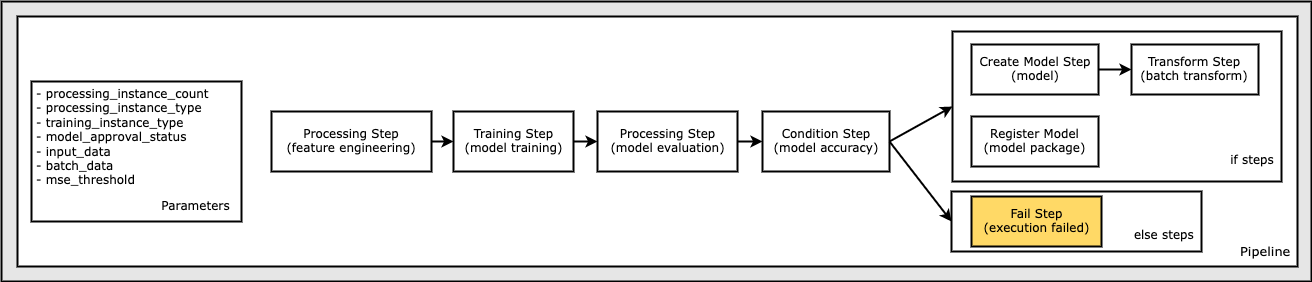

------
 ### Transformación por Lotes con un Modelo en SageMaker

## Pasos para Crear un Modelo

Para realizar una transformación por lotes, primero debes configurar un modelo en SageMaker.

### Cómo Configurar el Modelo

1. **Utilizar Artefactos del Modelo**:
   - Usa los `S3ModelArtifacts` de `step_train`, que contienen los datos del modelo entrenado. Esto garantiza que estás empleando el modelo correcto para tus transformaciones.

2. **Propiedades del Paso de Entrenamiento**:
   - Las propiedades de `TrainingStep` se alinean con el objeto de respuesta (`DescribeTrainingJob`), facilitando el acceso a los resultados del modelo.


## ¿Cómo lo Haremos?

1. **Definir una Condición**:
   - Vamos a crear una condición llamada `ConditionLessThanOrEqualTo`. Esta condición revisará si el valor de precisión (accuracy) del modelo, obtenido en el paso de evaluación (`step_eval`), es menor o igual a un umbral que definamos.

2. **Usar la Condición**:
   - Añadimos esta condición a una lista que será utilizada en un paso llamado `ConditionStep`. Este paso determinará qué hacer basado en si la condición es verdadera o falsa.

3. **Acciones si la Condición es Verdadera**:
   - Si la condición se cumple (es verdadera). Entonces, el pipeline ejecutará una serie de pasos que incluyen:
     - **CreateModelStep**: Crear un modelo.
     - **TransformStep**: Realizar transformaciones en los datos.
     - **RegisterModel**: Registrar el modelo para que se pueda usar más adelante.

4. **Acciones si la Condición es Falsa**:
   - Si la condición no se cumple (es falsa), se ejecutará:
     - **FailStep**: Un paso que indica que algo no salió como esperábamos, deteniendo el pipeline.

### ¿Por Qué Usar Condiciones?

El uso de condiciones permite que tu pipeline tome decisiones automáticamente basadas en criterios que tú defines, como qué tan bien está funcionando tu modelo. Esto significa que puedes automatizar respuestas a resultados de modelos, como si deben ser desplegados o si necesitas hacer más ajustes.

In [46]:
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet


cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="regression_metrics.mse.value",
    ),
    right=mse_threshold,
)

step_cond = ConditionStep(
    name="AbaloneMSECond",
    conditions=[cond_lte],
    if_steps=[step_register, step_create_model, step_transform],
    else_steps=[step_fail],
)

### Definir una tubería de parámetros, pasos y condiciones: 

En esta sección, combine los pasos en un pipeline para que pueda ejecutarse.

Una canalización requiere name, parameters, y steps. Los nombres deben ser únicos dentro de un par.(account, region)

Nota:

Todos los parámetros utilizados en las definiciones deben estar presentes.

Los pasos que se pasan al pipeline no tienen que enumerarse en el orden de ejecución. El servicio SageMaker Pipeline resuelve el DAG de dependencia de datos como pasos para que la ejecución se complete.

Los pasos deben ser únicos en toda la lista de pasos de la canalización y en todas las listas if/else de los pasos de condición.

In [47]:
from sagemaker.workflow.pipeline import Pipeline


pipeline_name = f"AbalonePipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        instance_type,
        model_approval_status,
        input_data,
        batch_data,
        mse_threshold,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
)

In [48]:
import json


definition = json.loads(pipeline.definition())
definition

[03/30/25 23:41:51] WARNING  Popping out 'ProcessingJobName'    ]8;id=612108;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=682788;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             from the pipeline definition by                    
                             default since it will be                           
                             overridden at pipeline execution                   
                             time. Please utilize the                           
                             PipelineDefinitionConfig to                        
                             persist this field in the pipeline                 
                             definition if desired.                             
                    WARNING  Popping out 'TrainingJobName' from ]8;id=223579;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/ut

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceCount',
   'Type': 'Integer',
   'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-221082178761/abalone/abalone-dataset.csv'},
  {'Name': 'BatchData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-221082178761/abalone/abalone-dataset-batch'},
  {'Name': 'MseThreshold', 'Type': 'Float', 'DefaultValue': 6.0}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'AbaloneProcess',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.xlarge',
      'InstanceCount': {'Get': 'Para

In [49]:
pipeline.upsert(role_arn=role)

[03/30/25 23:42:01] WARNING  Popping out 'ProcessingJobName'    ]8;id=265254;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=969861;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             from the pipeline definition by                    
                             default since it will be                           
                             overridden at pipeline execution                   
                             time. Please utilize the                           
                             PipelineDefinitionConfig to                        
                             persist this field in the pipeline                 
                             definition if desired.                             
                    WARNING  Popping out 'TrainingJobName' from ]8;id=239810;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/ut

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:221082178761:pipeline/AbalonePipeline',
 'ResponseMetadata': {'RequestId': '3d23a8a9-f049-4c4c-8d4f-3efb3f33eab2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3d23a8a9-f049-4c4c-8d4f-3efb3f33eab2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '83',
   'date': 'Sun, 30 Mar 2025 23:42:02 GMT'},
  'RetryAttempts': 0}}

In [50]:
execution = pipeline.start()

In [51]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:221082178761:pipeline/AbalonePipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:221082178761:pipeline/AbalonePipeline/execution/st7q1v2tvcpp',
 'PipelineExecutionDisplayName': 'execution-1743378132535',
 'PipelineExecutionStatus': 'Failed',
 'PipelineExperimentConfig': {'ExperimentName': 'abalonepipeline',
  'TrialName': 'st7q1v2tvcpp'},
 'FailureReason': 'Step failure: One or multiple steps failed.',
 'CreationTime': datetime.datetime(2025, 3, 30, 23, 42, 12, 433000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 3, 30, 23, 42, 16, 433000, tzinfo=tzlocal()),
 'CreatedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::221082178761:assumed-role/AmazonSageMaker-ExecutionRole-20250330T132053/SageMaker',
   'PrincipalId': 'AROATG6MGKTEZNJAQFCZU:SageMaker'}},
 'LastModifiedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::221082178761:assumed-role/AmazonSageMaker-ExecutionRole-20250330T132053/SageMaker',
   'PrincipalId': 'AROATG6

In [ ]:
execution.wait()

In [ ]:
execution.list_steps()